In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import metrics

## Importing the data

In [2]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


### Choosing the variables to use

In [3]:
df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration_s"] = df["duration"].apply(lambda x: x.total_seconds() / 60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,duration_s
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04,0.066667


In [4]:
df = df[(df["duration_s"] >= 1) & (df["duration_s"] <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

# passing to string
df[categorical] = df[categorical].astype(str)

### Manual scikit implementation

In [20]:
train_dicts = df[categorical + numerical].to_dict(orient="records")
dv = feature_extraction.DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
target = 'duration_s'
y_train = df[target].values

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
metrics.mean_squared_error(y_train, y_pred, squared=False)

9.775258694528294

/home/luba/.local/share/virtualenvs/mlops-zoomcamp-4Pi15hoo/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/luba/.local/share/virtualenvs/mlops-zoomcamp-4Pi15hoo/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


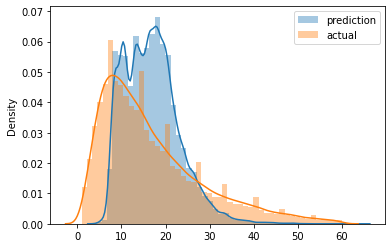

In [21]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.legend()

### Pipeline scikit implementation

Here we are creating a custom transformer to convert our dataframe to dictionary and after that will input on the `DictVectorizer` transformation.

I'm using cross_val_score, that will get our data and validate on a hold out dataset to evaluate how well it is going. But, we can also use `cross_validate` method to return the model after the training.

And, with this implementation is easier to experiment different params using `grid_search` for example.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# custom transform
class ToDictTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.columns:
            X = X[self.columns]
        else:
            X = X['PULocationID', 'DOLocationID', 'trip_distance']

        X = X.to_dict(orient="records")
        return X

In [22]:
# making a pipeline Linear Regression
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

features = categorical + numerical
X_train = df[features]
y_train = df["duration_s"]

pipe = pipeline.Pipeline(
    [
        ("transform_to_dict", ToDictTransformer(columns=features)),
        ("dict_vectorization", feature_extraction.DictVectorizer(sparse=False)),
        ("linear_model", linear_model.LinearRegression()),
    ]
)

results = cross_val_score(
    pipe, X_train, y_train, cv=4, error_score="raise", scoring="neg_mean_absolute_error"
)
results * -1


array([6.27745077, 6.18790862, 8.71306491, 8.99430334])

In [23]:
# making a pipeline for a Lasso Regression
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

features = categorical + numerical
X_train = df[features]
y_train = df["duration_s"]

pipe = pipeline.Pipeline(
    [
        ("transform_to_dict", ToDictTransformer(columns=features)),
        ("dict_vectorization", feature_extraction.DictVectorizer(sparse=False)),
        ("linear_model", linear_model.Lasso()),
    ]
)

results = cross_val_score(
    pipe, X_train, y_train, cv=4, error_score="raise", scoring="neg_mean_absolute_error"
)
results * -1

array([9.36911265, 9.27796094, 9.24196141, 9.56682492])